# Walmart Sales: model regularization, selection and validation

In this notebook I selected the best regressor to predict weekly sales from the Wallmart Sales data[(Kaggle competition)](https://www.kaggle.com/competitions/walmart-sales-forecasting/overview).  
 
 In more detail, I:  
- Validated a first linear regressor I trained on the data:  
    - Evaluated **model performance** throught a **cross validation**  
    - **Optimized** my linear **model** via **regularization** and **grid search** for hypeparameter tuning
- Compared my linear model to another regressor: Random Forest Regressor


## Table of Contents  
1. Linear regressor: regularization
2. Random Forest Regressor 
3. Crossvalidation of best model
4. Export best model pipeline  
5. Conclusions

## Import libraries

In [57]:
import pandas as pd
import numpy as np

import scipy.sparse

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import joblib

# Import my own functions
from src.features.build_features import basic_preprocessor

# Plotting config
sns.set_theme(style="white")

## Import train and test datasets

In [58]:
# Load unsplit target variable
filename = 'data/interim/Walmart_Store_sales-targetvar.csv'
with open(filename) as file:
    Y = [float(line.rstrip()) for line in file]

print('Target variable length:',len(Y))
Y[0:5]

Target variable length: 131


[1572117.54, 1807545.43, 1244390.03, 1644470.66, 1857533.7]

In [59]:
# Load target variable : split into train and test
filename = 'data/processed/Walmart_Store_sales-target-train-basic.csv'
with open(filename) as file:
    y_train = [float(line.rstrip()) for line in file]

filename = 'data/processed/Walmart_Store_sales-target-test-basic.csv'
with open(filename) as file:
    y_test = [float(line.rstrip()) for line in file]

print('Target train length:', len(y_train))
print('Target test length:', len(y_test))
print(y_train[:5])


Target train length: 104
Target test length: 27
[2066541.86, 1539483.7, 1205307.5, 1256282.79, 301827.36]


In [60]:
# Load unprocessed explanatory variables
X_basic_df = pd.read_csv('data/interim/Walmart_Store_sales-expvar-basic.csv')
X_basic_df.drop(['year'], axis=1, inplace=True)
print('Basic explanatory variables shape:', X_basic_df.shape)

basic_vars_ls = X_basic_df.columns.tolist()
print('Basic explanatory variables:', basic_vars_ls)

X_basic = X_basic_df.values

X_basic[0:3,:]

Basic explanatory variables shape: (131, 8)
Basic explanatory variables: ['Store_str', 'quarter', 'Fuel_Price', 'weekofyear', 'Holiday_Flag', 'Temperature', 'CPI', 'Unemployment']


array([[  6.        ,   1.        ,   3.045     ,   7.        ,
                 nan,  15.33888889, 214.7775231 ,   6.858     ],
       [ 13.        ,   1.        ,   3.435     ,  12.        ,
          0.        ,   5.76666667, 128.6160645 ,   7.47      ],
       [ 11.        ,          nan,          nan,          nan,
          0.        ,  29.20555556, 214.5564968 ,   7.346     ]])

In [61]:
# Load preprocessed explanatory variables(train and test split)
X_train = scipy.sparse.load_npz('data/processed/Walmart_Store_sales-expvar-train-basic.npz')
X_test = scipy.sparse.load_npz('data/processed/Walmart_Store_sales-expvar-test-basic.npz')

print('X train shape:', X_train.shape)
print('X test shape:', X_test.shape)
print(X_train)

X train shape: (104, 27)
X test shape: (27, 27)
  (0, 0)	0.3080695702984372
  (0, 1)	0.11450362432338515
  (0, 2)	1.4631556723366952
  (0, 3)	-1.8421346343631164
  (0, 6)	1.0
  (0, 23)	1.0
  (0, 26)	-1.1494375279696578
  (1, 0)	-0.04811858638413535
  (1, 1)	1.5648828657529306
  (1, 2)	0.13891797016022916
  (1, 3)	0.5227467779469824
  (1, 24)	1.0
  (1, 26)	1.069566022312942
  (2, 0)	-1.1985399620048696
  (2, 1)	-0.07633574954892344
  (2, 2)	-2.286677677693888
  (2, 3)	1.9446556739174115
  (2, 19)	1.0
  (2, 22)	1.0
  (2, 26)	-1.0892881839506041
  (3, 0)	-0.937482803690934
  (3, 1)	-0.3435108729701555
  (3, 2)	0.546147738018435
  (3, 3)	0.08585036941714648
  (3, 19)	1.0
  :	:
  (100, 2)	0.926703066933964
  (100, 3)	-0.18927197310407765
  (100, 5)	1.0
  (100, 24)	1.0
  (100, 26)	-1.2071886908871303
  (101, 0)	1.529286107495832
  (101, 1)	-1.1068683684593899
  (101, 2)	-0.7401529843284452
  (101, 3)	0.6046981140171344
  (101, 16)	1.0
  (101, 26)	-0.9384671807959556
  (102, 0)	0.657620680583

## R2 score for simple linear regressor

In [62]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("R2 score on training set (linear regressor) : ", regressor.score(X_train, y_train))
print("R2 score on test set (linrear regressor) : ", regressor.score(X_test, y_test))

R2 score on training set (linear regressor) :  0.9721495512292556
R2 score on test set (linrear regressor) :  0.9277245415698245


## 1. Linear regressor: regularization  

Use Ridge and Lasso regularization to see if overfitting of model can be reduced  
Carry out a gridsearch for each regressor to define best hyperparameters to use

### Ridge: L2 regularization

In [63]:
# Perform Grid Search for best parameters for regressors
regressor_ridge = Ridge()

# Grid of values to be tested: (alpha ==0 is equivalent to ordinary least squares solved by a linear regressor; tol = precision of the solution - default 1e-03)
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 1.5],
    'tol': [1e-05, 1e-04, 1e-03]
}
gridsearch = GridSearchCV(regressor_ridge, param_grid = params, cv = 10)
gridsearch.fit(X_train, y_train)

print("Best hyperparameters for Ridge regressor: ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Best hyperparameters for Ridge regressor:  {'alpha': 0.1, 'tol': 0.0001}
Best R2 score :  0.935572917665486


In [64]:
# Predic target using Ridge with best parameter alpha
y_train_pred = gridsearch.predict(X_train)
y_test_pred = gridsearch.predict(X_test)

In [65]:
# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set (Ridge) : ", r2_score(y_train, y_train_pred))
print("R2 score on test set (Ridge) : ", r2_score(y_test, y_test_pred))


R2 score on training set (Ridge) :  0.9705136193716631
R2 score on test set (Ridge) :  0.9369008051527893


### Lasso : L1 regularization

In [66]:
# Perform Grid Search for best parameters for regressors
regressor_lasso = Lasso()

# Grid of values to be tested: alpha and tolerance
# Since lasso is made for 
params = {
    'alpha': [0.1, 0.5, 1.0, 1.5],
    'tol': [1e-05, 1e-04, 1e-03]
}
gridsearch_lass = GridSearchCV(regressor_lasso, param_grid = params, cv = 5)
gridsearch_lass.fit(X_train, y_train)

print("Best hyperparameters for Lasso regressor: ", gridsearch_lass.best_params_)
print("Best R2 score : ", gridsearch_lass.best_score_)

Best hyperparameters for Lasso regressor:  {'alpha': 1.5, 'tol': 1e-05}
Best R2 score :  0.9394062102475413


In [67]:
# Predic target using Ridge with best parameter alpha
y_train_pred = gridsearch_lass.predict(X_train)
y_test_pred = gridsearch_lass.predict(X_test)

# Print R^2 scores on train/test sets for the LAsso model with optimal hyperparameters
print("R2 score on training set (Lasso) : ", r2_score(y_train, y_train_pred))
print("R2 score on test set (Lasso) : ", r2_score(y_test, y_test_pred))

R2 score on training set (Lasso) :  0.9721495424877364
R2 score on test set (Lasso) :  0.9277626222406021


## 2. Random Forest Regressor

First use RandomizedSearch to narrow down the hyperparameters to use  
Secondly use GridSearch to fine tune on search for hyperparameters  

 
 *Randomized search code based on Hyperparameter tuning publication by Will Koehrsen*

### Randomized hyperparemeter search

In [68]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [69]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
regressor_rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomsearch = RandomizedSearchCV(estimator = regressor_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
randomsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [70]:
# Best hyperparameters found
print("Best hyperparameters for Random Forest regressor: ", randomsearch.best_params_)

Best hyperparameters for Random Forest regressor:  {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


### Gridsearch hyperparameter tuning

In [71]:
# Fine tune hyperparameter search

# Perform Grid Search for best parameters for regressors
regressor_rf = RandomForestRegressor()

# Grid of values to be tested: (alpha ==0 is equivalent to ordinary least squares solved by a linear regressor; tol = precision of the solution - default 1e-03)
params = {
    'max_depth': [80, 90, 100, 110],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [500, 600, 700, 800]
}
gridsearch_rf = GridSearchCV(regressor_rf, param_grid = params, cv=5 ,verbose=0, n_jobs = -1)
gridsearch_rf.fit(X_train, y_train)

print("Best hyperparameters for Random Forest regressor: ", gridsearch_rf.best_params_)
print("Best R2 score Random Forest : ", gridsearch_rf.best_score_)


Best hyperparameters for Random Forest regressor:  {'max_depth': 80, 'min_samples_split': 4, 'n_estimators': 500}
Best R2 score Random Forest :  0.7642065942717025


In [72]:
# Predic target using Ridge with best parameter alpha
y_train_pred = gridsearch_rf.predict(X_train)
y_test_pred = gridsearch_rf.predict(X_test)

# Print R^2 scores on train/test sets for the Random Forest regressor  with optimal hyperparameters
print("R2 score on training set (Random Forest Regressor) : ", r2_score(y_train, y_train_pred))
print("R2 score on test set (Random Forest Regressor) : ", r2_score(y_test, y_test_pred))

R2 score on training set (Random Forest Regressor) :  0.9691499833706844
R2 score on test set (Random Forest Regressor) :  0.6755884657477307


## 3. Cross validation of best model  

Based on regularization results and test of random forest regressor, will keep the linear model with Ridge regularization as the best model  
 
 Carry out crossvalidation to test the performance of the chosen model

In [73]:
# Pipeline of best model: pre-processing with basic pre-processor  and linear regressor with Ridge regularization
best_model_pipeline = Pipeline([
        ('preprocessing', basic_preprocessor),
        ('lin_reg', Ridge(alpha=1.5, tol=1e-05))
    ])

In [74]:
# Cross validate using basic regressor pipeline which includes pre-processing and linear regressor 

cross_val_scores = cross_val_score(best_model_pipeline, X_basic, Y, cv=10)

print('Cross validation results for linear regressor with basic processor and Ridge regularization:')
print("%0.2f mean accuracy with a mean standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))

Cross validation results for linear regressor with basic processor and Ridge regularization:
0.87 mean accuracy with a mean standard deviation of 0.07


In [75]:
# Cross validate to obtain test and train scores as well as fit and score time
scores = cross_validate(best_model_pipeline, X_basic, Y, return_train_score=True, cv=10)
scores_df = pd.DataFrame(scores).reset_index().rename(columns={'index':'cv'})
scores_df.head()

,cv,fit_time,score_time,test_score,train_score
0,0,0.007108,0.001552,0.773207,0.925917
1,1,0.005262,0.001357,0.894600,0.915794
2,2,0.005033,0.001316,0.889897,0.915664
3,3,0.005152,0.001299,0.871695,0.919154
4,4,0.005000,0.001304,0.749134,0.921283


In [76]:
# Dataframes a for plotting of scores 
scores_df_plot = pd.melt(scores_df, id_vars=['cv'], value_vars=['test_score', 'train_score'])
display(scores_df_plot.head())

time_df_plot = pd.melt(scores_df, id_vars=['cv'], value_vars=['fit_time', 'score_time'])
display(time_df_plot.head())

,cv,variable,value
0,0,test_score,0.773207
1,1,test_score,0.894600
2,2,test_score,0.889897
3,3,test_score,0.871695
4,4,test_score,0.749134


,cv,variable,value
0,0,fit_time,0.007108
1,1,fit_time,0.005262
2,2,fit_time,0.005033
3,3,fit_time,0.005152
4,4,fit_time,0.005000


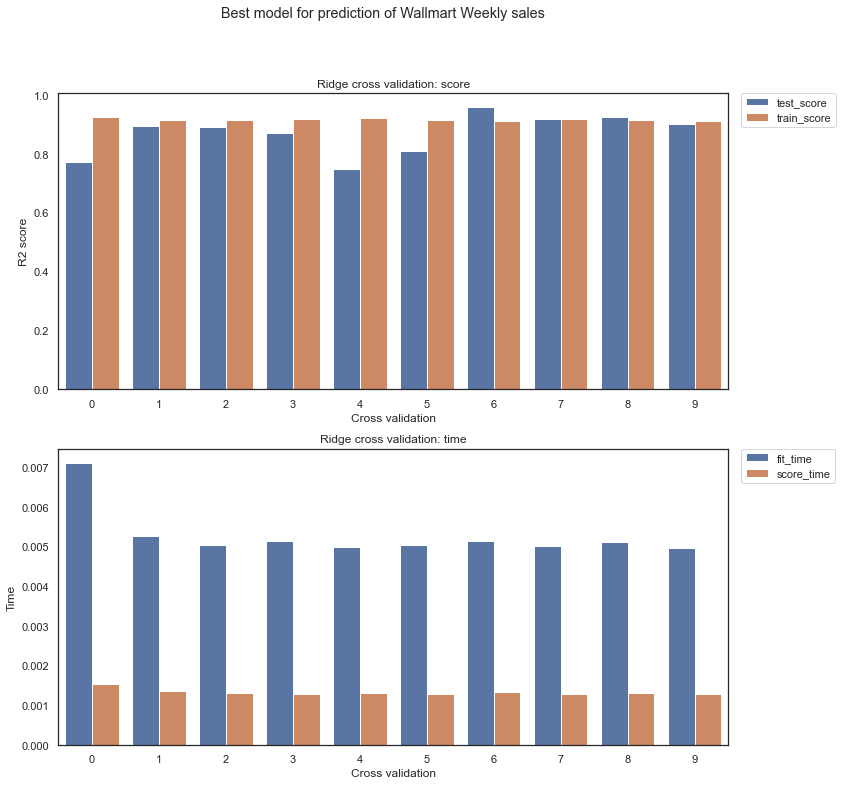

In [79]:
# Plot

# Set axes for grid and figure size
figure, axes = plt.subplots(2, 1, figsize=(12,12))


fig1 = sns.barplot(x="cv", y="value", hue="variable", data=scores_df_plot, ax=axes[0])
fig1.set(title = 'Ridge cross validation: score', xlabel='Cross validation', ylabel='R2 score')
fig1.legend(title="", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig2 = sns.barplot(x="cv", y="value", hue="variable", data=time_df_plot, ax=axes[1])
fig2.set(title = 'Ridge cross validation: time', xlabel='Cross validation', ylabel='Time')
fig2.legend(title="", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Export image in results
plt.suptitle("Best model for prediction of Wallmart Weekly sales")
plt.savefig('results/04-Best_model_Ridge_crossval.png', bbox_inches='tight')

## 4. Export best model pipeline

In [78]:
joblib.dump(best_model_pipeline, "models/pipeline_preprocess_ridgepredictor.joblib")

['models/pipeline_preprocess_ridgepredictor.joblib']

## 5. Conclusions

* The linear regressor resulted in a better accuracy of prediction compared the a random forest regressor  
 
 * Ridge regularization with an alpha of 0.1 and precision of 1e-05 (tol) resulted in a reduction of the overfitting observed with the linear regressor. The reduction of overfitting was probably not as strong due to the low number of overall samples (n = 136)  
 
 * A cross validation of the best model (Ridge regularization) indicated that the model was quite stable with a mean R2 score of 0.87 and mean standard deviation of 0.07  


